# **IMPORT**

In [2]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time
from skimage.measure import compare_ssim
import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.utils import to_categorical
import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
np.random.seed(0)

# **GLOBAL VARIABLES**

Values given in the paper


In [0]:
INDIVIDUALS = 50
P_CROSS = 0.6
P_MUTATION = 0.1

# **THE DATA**

1. MNIST

Pre-processing necessary before training the network

In [5]:
# load mnist
(x_train, y), (x_test, y_t) = tf.keras.datasets.mnist.load_data()

# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])
print('y_train shape:', y.shape)
print('y_test shape:', y_t.shape)


11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000
y_train shape: (60000,)
y_test shape: (10000,)


2. CIFAR 10 

In [0]:
from keras.datasets import cifar10

# The data, split between train and test sets:
(x_train_C, y_train_C), (x_test_C, y_test_C) = cifar10.load_data()
print('x_train shape:', x_train_C.shape)
print(x_train_C.shape[0], 'train samples')
print(x_test_C.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes=10
epochs=10
img_shape=32 
y_train_C = to_categorical(y_train_C, num_classes)
y_test_C = to_categorical(y_test_C, num_classes)


input_shape=(32,32,1)

x_train_C = x_train_C.astype('float32')
x_test_C = x_test_C.astype('float32')
x_train_C /= 255
x_test_C /= 255


print('x_train shape:', x_train_C.shape)
print('Number of images in x_train', x_train_C.shape[0])
print('Number of images in x_test', x_test_C.shape[0])
print('y_train shape:', y_train_C.shape)
print("input shape: ",input_shape)


# CONVERT TO GRAY SCALE

import matplotlib.pyplot as plt
import numpy as np

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

x_train_C = grayscale(x_train_C)
x_test_C = grayscale(x_test_C)

# now we have only one channel in the images
img_channels = 1



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
x_train shape: (50000, 32, 32, 3)
Number of images in x_train 50000
Number of images in x_test 10000
y_train shape: (50000, 10)
input shape:  (32, 32, 1)



# **READY PICKLE FILE**

In [0]:
with open('subset', 'rb') as f:
    original = pickle.load(f)
    adversarial= pickle.load(f)
    original_y = pickle.load(f)
    adversarial_y = pickle.load(f)

In [123]:
print(f"Original shape {original.shape}")
print(f"Adversarial shape {adversarial.shape}")
print(f"Original labels shape {original_y.shape}")
print(f"Adversarial labels shape {adversarial_y.shape}")

Original shape (895, 784)
Adversarial shape (126, 784)
Original labels shape (895,)
Adversarial labels shape (126,)


Normalize images

In [0]:
adversarial = adversarial / 255.

Original images

Label 0


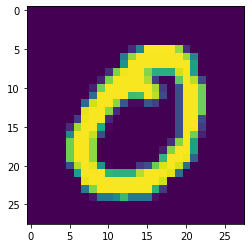

In [125]:
print("Original images\n")
plt.imshow(original[0].reshape(28,28))
print(f"Label {original_y[0]}")

Adversarial images

Label 0


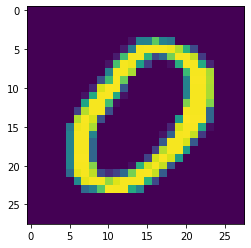

In [64]:
print("Adversarial images\n")
plt.imshow(adversarial[0].reshape(28,28))
print(f"Label {adversarial_y[0]}")

# **LOAD/TRAIN MODEL**

1. SVM

In [0]:
'''svm = SVC(C=1, kernel='rbf')
svm.fit(X, y)
svm.score(X_t, y_t)
save_model(svm)
'''

# first ran the function downstairs to initialize load_trained_model

model = load_trained_model("SVC_model.sav")


2. Original CNN

The network from Petra's 2020 paper, from the Appendix. This network is used for training MNIST, and has training accuracy 0.9871, test accuracy 0.9907 . 

In [10]:
# change labels to categorical before training
num_classes=10
y_train = to_categorical(y, num_classes)
y_test = to_categorical(y_t, num_classes)

# CNN from the Appendix of the 2020 paper 


inp = Input(shape=input_shape)
conv1 = Conv2D(32, (3,3),activation='relu')(inp)
conv2 = Conv2D(32, (3,3),activation='relu')(conv1)
max_pool1 = MaxPooling2D(pool_size=(2, 2))(conv2)
drop = Dropout(0.25)(max_pool1)
flat =  Flatten()(drop)
dense1 = Dense(128,activation="relu")(flat)
drop = Dropout(0.5)(dense1)
predictions = Dense(10,activation="softmax")(drop) # softmax layer 
model = Model(inputs=[inp], outputs=[predictions])

model.summary() 

model.compile(optimizer='Adadelta', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

'''
history = model.fit(x=x_train,y=y_train, epochs=10, validation_data=[x_test,y_test])

score= model.evaluate(x_test, y_test,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

'''
'''
model.save_weights("CNN_MNIST.h5")
model.save("MNIST_CNN.h5")
'''


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5899

'\nmodel.save_weights("CNN_MNIST.h5")\nmodel.save("MNIST_CNN.h5")\n'

In [0]:

model = load_model("MNIST_CNN.h5")

3. CNN v2

This network is made for CIFAR 10. The network is taken from [this blog]( https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/) . In this version below I didn't use some things used in the blog e.g. z-score and data augmentation.


This network has training accuracy: 0.8940 , validation accuracy: 0.8245.

**NOTE:** Training really slow, try to avoid it.


In [0]:
# Network 3 
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
 
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


'''
history = model.fit(x=x_train_C,y=y_train_C, epochs=150, batch_size=64, validation_data=[x_test_C,y_test_C])

score= model.evaluate(x_test_C, y_test_C,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save_weights("CNN_CIFAR10_net3.h5")
files.download('CNN_CIFAR10_net3.h5')
'''

model = load_model("CNN_CIFAR10_net3.h5")

# **OPERATOR FUNCTIONS**

In [181]:

'''
def euclidean(s):
    # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

def euc_fitness(individual, target, pred, label, l1=0.5, l2=0.5, N = 50, n_classes=10):
    # petras fitness fucntion
    return -(l1*euclidean(individual-target)/N + l2*euclidean(pred-label)/n_classes)
'''

def computing_SSIM(individual,target):
    (score, diff) = compare_ssim(individual, target, full=True)
    #diff = (diff * 255).astype("uint8")
    return score

def calculate_fitness(model,ind,target_image,label,l1=0.5, l2=0.5, N=50, num_classes=10):
  # predict the population
  predictions=model.predict(ind.reshape(1,28,28,1)) 
  # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
  predictions=predictions[0]
  po=predictions[label]
  # set that value to 0
  predictions[label]=0
  # take next highest one
  pd = np.max(predictions)
  diff=pd-po
  return -(l1*computing_SSIM(ind.reshape(28,28),target_image)/N + l2*(diff)/num_classes)


def pop_fitness(model,pop,target,label):
    return [calculate_fitness(model, p, target, label) for p in pop]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, np.sqrt(0.1))

def p_noise(x):
  if P_MUTATION > np.random.uniform():
    return x + gaussian_noise()
  else:
    return x
    
def add_noise(image):
    noise_v=np.vectorize(p_noise)
    return noise_v(image) #np.array([x + gaussian_noise() if P_MUTATION > np.random.uniform(0.0, 1.0) else x+0 for x in image])

def k_crossover(im1, im2, k=2):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, 783, 1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, model, ground_truth, target, k=3):
    #predictions=model.predict(pop.reshape(50,28,28,1))
    #predictions=predictions[0]
    indices = np.random.choice(range(len(pop)), k, replace=False) #we get 3 indxes [2 34 46]
    individuals = pop.take(indices,axis=0)
    scores = [pop_fitness(model,np.expand_dims(individuals.reshape(individuals.shape[0],28,28),axis=3), ground_truth.reshape(28,28), target)]
    
    index_min = max(range(len(scores[0])), key=scores[0].__getitem__)
   
    return pop[index_min]

def check_adverserial(pop, model, fitness, target):
    preds=model.predict(pop.reshape(50,28,28,1))
    preds=preds[0]
    for ind, pred, f in zip(pop, preds, fitness):
        if pred == target and f < 0.01:
            return ind
        return None

def init_pop(n, num, data, labels):
    indices = np.where(labels==num)[0]
    n_indices = np.random.choice(indices, n, replace=True)
    sample = np.take(data, n_indices, axis=0)
    return sample, np.full((n), num, dtype=int) # return sample+array of labels

def init_pop_from_sample(n,img,label):
    #indices = np.where(labels==num)[0]
    #index = np.random.choice(indices, 1)
    #sample = np.take(data, index, axis=0)
    x = np.array([add_noise(img) for i in range(n)])
    return x.reshape(n, 784)
'''
Cyrils model

def save_trained_model(model, filename='SVC_model.sav'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_trained_model(filename='SVC_model.sav'):
    return pickle.load(open(filename, 'rb'))

'''

"\nCyrils model\n\ndef save_trained_model(model, filename='SVC_model.sav'):\n    pickle.dump(model, open(filename, 'wb'))\n    \ndef load_trained_model(filename='SVC_model.sav'):\n    return pickle.load(open(filename, 'rb'))\n\n"

In [0]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):

  # reshape parents
  parent_1,parent_2= parent_1.reshape((28,28)), parent_2.reshape((28,28))
  # quadrants for both parents
  p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
  child1, child2 = [],[]
  # getting random (x,y) point in 2D matrix
  x,y = np.random.randint(0,27), np.random.randint(0,27)  ## here to pun len of row and len of column 

  # choose which quadrant we want to crossover
  N = np.random.randint(0,3)
  #make quadrants
  for i in range(28):
    if (i<=x):
      p1.append(parent_1[i][:y+1])
      p2.append(parent_1[i][y+1:])
      q1.append(parent_2[i][:y+1])
      q2.append(parent_2[i][y+1:])
    else:
      p3.append(parent_1[i][:y+1])
      p4.append(parent_1[i][y+1:])
      q3.append(parent_2[i][:y+1])
      q4.append(parent_2[i][y+1:])

  helper=[]
  if (N==0):
    ch1 = connect_quadrants(p1,q2,q3,q4)
    ch2 = connect_quadrants(q1,p2,p3,p4)
  elif (N==1):
    ch1 = connect_quadrants(q1,p2,q3,q4)
    ch2 = connect_quadrants(p1,q2,p3,p4)
  elif (N==2):
    ch1 = connect_quadrants(q1,q2,p3,q4)
    ch2 = connect_quadrants(p1,p2,q3,p4)
  else:
    ch1 = connect_quadrants(q1,q2,q3,p4)
    ch2 = connect_quadrants(p1,p2,p3,q4)

  return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
  left = np.concatenate((q1,q3))
  right = np.concatenate((q2,q4))
  image = np.concatenate((left,right),axis=1)
  return image.flatten()


def multi_crossover(parent1,parent2,target):
  pop= []
  # 2-k crossover
  pop.append(k_crossover(parent1, parent2))
  # Gorge Clooney crossover
  pop.append(quadrant_crossover(parent1,parent2))
  # uniform crossover
  pop.append(k_crossover(parent1, parent2,1))
  # SSIM similarity 
  flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
  len(flattened_list)
  ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
  ids = np.argpartition(ssim, 2)[:2]

  return flattened_list[ids[0]],flattened_list[ids[1]]
  


# **THE MAIN FUNCTION**

Flatten data before evolving

In [16]:
'''
This not necessary when using subset 
'''
'''
X = flatten(x_train)
X_t = flatten(x_test)
print(f"X train shape {X.shape}")
print(f"X test shape {X_t.shape}")
print(f"y train shape {y.shape}")
print(f"y test shape {y_t.shape}")
'''

X train shape (60000, 784)
X test shape (10000, 784)
y train shape (60000,)
y test shape (10000,)


In [0]:
adversarial[0].reshape(28,28,1)

# **MAIN FUNCTION**

In [0]:
# for each image and label in adversarial
n=50
for img,label in zip(adversarial,adversarial_y):
  #intialize population from the image and with the given label
  population = init_pop_from_sample(n,img,label)
  print(population.shape)
  # calculate fitness of these individuals
  fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],28,28),axis=3),img.reshape(28,28),label)
  
  #check if adversarial
  adv=check_adverserial(population,model,fitness,label)

  max_gen=0
  
  while adv==False or max_gen<10000:
    new_pop=[]
    for i in range(25):
      parent1= tournament(population, model, img, label) 
      parent2 = tournament(population, model, img, label)
      if 0.6 > np.random.uniform(0.0, 1.0):
        child1, child2 = multi_crossover(parent1, parent2,img) # crossover 
        child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels     
        new_pop.append(child1)
        new_pop.append(child2)
      else:
        new_pop.append(add_noise(parent1))
        new_pop.append(add_noise(parent2))

    #new_pop=new_pop[50:]
    #to reshape
    population= np.array(new_pop)
    fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],28,28),axis=3),img.reshape(28,28),label)  
    max_gen+=1
    if (max_gen % 10 == 0):
      print(f"Generation {max_gen}")
      print(f"Max fitness value {np.max(fitness)}")
    
    adv = check_adverserial(population,model,fitness,label) 
  
  #show adversarial
  
  if(adv != None):
    plt.imshow(adv.reshape(28,28))
  else:
    print(f" We came to {max_gen} th round")





# **CYRILS FUNCTION**

In [0]:
'''def ga(num, data, labels, max_gen, target, individuals = INDIVIDUALS, p_cross = P_CROSS, p_mut = P_MUTATION):
    
    # initialize population by drawing 1 sample from passed dataset, automatically applies noise to all copies
    # Then take predictions to calculate population fitness
    pop, ground_truth = init_pop_from_sample(individuals, num, data, labels)
    #predictions = model.predict(pop)
    fit_vals = calculate_fitness(model,pop, ground_truth, label)

    for gen in range(max_gen):
        if gen % 10 == 0:
            print(f'fitting gen: {gen}')
            print(fit_vals)

        adverserial = check_adverserial(pop, predictions, fit_vals, target)
        if adverserial:
            return adverserial
        
        new_pop = []
        for i in range(individuals//2):
                            
            parent1, idx1 = tournament_selection(pop, predictions, ground_truth, target) 
            parent2, idx2 = tournament_selection(pop, predictions, ground_truth, target)
            if p_cross > np.random.uniform(0.0, 1.0):
                
                #child1, child2 = np.array([]), np.array([])
                child1, child2 = multi_crossover(parent1, parent2) # crossover
                
                child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels     
                #if child1.size != 0:
                new_pop.append(child1)
                new_pop.append(child2)
            else:
                new_pop.append(parent1)
                new_pop.append(parent2)
            #print(len(pop))
            #pop.pop(idx1[0])
            #pop.pop(idx2[0])
            if idx1 != idx2:
                order = sorted([idx1, idx2], reverse = True)
                pop = np.delete(pop, order[0], axis=0)
                pop = np.delete(pop, order[1], axis=0)
            else:
                order = idx1
                pop = np.delete(pop, order, axis=0)

            print(order)
            print(pop.shape)

                
        pop = np.array(new_pop)
        predictions = model.predict(pop)
        fit_vals = pop_fitness(pop, ground_truth, predictions, target)
    return pop[fit_vals.index(max(fit_vals))]
    
start = time.process_time()
adverserial = ga(7, X, y, 1, 1) #(num, data, labels, max_gen, target)
print(time.process_time() - start)
'''

# Examples of what functions do

In [0]:
for adv in adversarial_y:
  print(adv)

1. Init population 

In [17]:
print(f"Shape of our dataset {X.shape}")
population,ground_truth = init_pop_from_sample(INDIVIDUALS, 7, X, y)
'''
Here instead X and Y we will input adversarial X and adv_y

Loop for each item in it
'''

(60000, 784)


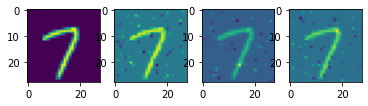

In [54]:
f, ax = plt.subplots(1,4)
ax[0].imshow(ground_truth.reshape(28,28))
ax[1].imshow(population[0].reshape(28,28))
ax[2].imshow(population[1].reshape(28,28))
ax[3].imshow(population[2].reshape(28,28))


2. Prediction and fitness functions


In [56]:
print(f"Population shape {population.shape}")
print(f"One sample from population shape {population[0].shape}")

Population shape (50, 784)
One sample from population shape (784,)


In [62]:
''' We need to expand the dimension because CNN requires (28,28,1) shape) '''
predictions = model.predict(np.expand_dims(population.reshape(population.shape[0],28,28),axis=3))
print("Example of predictions for 1st sample from population \n")
print(predictions[0])

Example of predictions for 1st sample from population 

[1.83606268e-08 1.87752196e-08 2.89226159e-06 2.00165414e-06
 5.12024805e-08 3.22582006e-09 6.12911588e-12 9.99759257e-01
 1.01414464e-07 2.35686341e-04]


Adversarial example

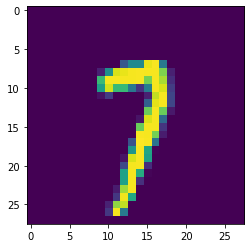

In [0]:
plt.imshow(adverserial.reshape(28,28))

In [0]:
model.predict(adverserial.reshape(1,-1))

array([7], dtype=uint8)

In [0]:
'''

Cyril's part

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, typecode="d", fitness=creator.FitnessMax, strategy=None)
creator.create("Strategy", np.ndarray, typecode="d")

tbx = base.Toolbox()
INDIVIDUAL_SIZE = 784


tbx.register("attr_int", random.randint, 0, 1)
tbx.register("individual", 
             tools.initRepeat, 
             creator.Individual,
             tbx.attr_int, 
             n=INDIVIDUAL_SIZE)
tbx.register("population", tools.initRepeat, list, tbx.individual)
tbx.register("evaluate", EOQ)
tbx.register("mate", tools.cxOnePoint)
tbx.register("mutate", tools.mutFlipBit, indpb=0.01)
tbx.register("select", tools.selTournament, tournsize=5)

'''